# Attention Pooling by Similarity

In this notebook we will be using the primary components of the attention mechanism in a classical setting involving regression and classification via kernel density estimation. This will serve simply as a way to solidify the background knowledge on the fundations of the attention mechanisms. 

(To be added the mathematical notation)

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

## Kernels and Data

All the kernels defined in this section are _translation and rotation invariant_, that is, if we shift and rotate __k__ and __q__ in the same manner, the value of alpha remains unchanged. 

Picking scalar arguments _k_, _q_ are Reals and _k = 0_ as the origin. 

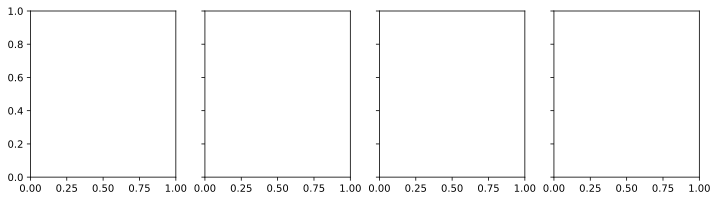

In [2]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

In [3]:
kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

## Attention Pooling via Nadaraya-Watson Regression

Please note that different kernels correspond to differetn notions of range and smoothness. For instance, the boxcar kernel only attends to observations within a distance of 1 (or some other defined hyperparameter) and does so indiscriminately. 

### Generating Training data for Nadaraya-Watson Estimator



In [5]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

Now that we have data and kernels, all we need is a function that computes the kernel regression estimates. Note that we also want to obtain the relative kernel weights in order to perform some minor diagnostics. Hence we first compute the kernel between all training features (covariates) x-train and all validation features x-val. This yields a matrix, which we subseuently normalize. When multiplied with the training labels y-train we obtain the estimates.

__In steps:__

* Compute the kernel between all training features x-train all validation features x-val
* The computation above generates a __matrix which is subsequently normalized__
* Multiply this matrix with the training labels y-train we obtain the estimates.

Let each _validation feature_ be a query, and each _training feature-label pair be a key-value pair_. As a result, the normalized relative kernel weights (attention-w below) are the attention weights. 

In [7]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

Let's have a look at the kind of estimates that the different kernels produce.

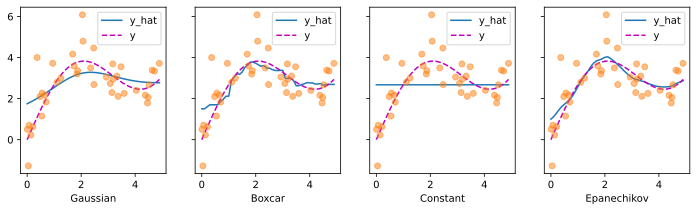

In [8]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

The first thing that stands out is that all three nontrivial kernels (Gaussian, Boxcar, and Epanechikov) produce fairly workable estimates that are not too far from the true function. Only the constant kernel that leads to the trivial estimate produces unrealistic results.

Let's inspect the attention weighting a bit more closely.

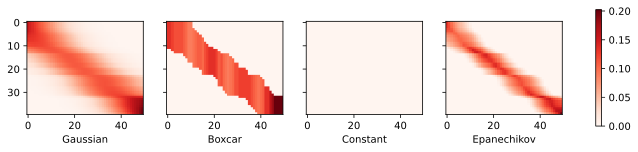

In [9]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The visualization clearly shows why the estimates for Gaussian, Boxcar, and Epanechikov are very similar: after all, they are derived from very similar attention weights, despicte the different functional form of the kernel. __This raises the question as to whether this is alway sthe case.__

## Adapting Attention Pooling

Replacing the Gaussian kernel with one of a different width. Let's see whether this affects the outcomes.

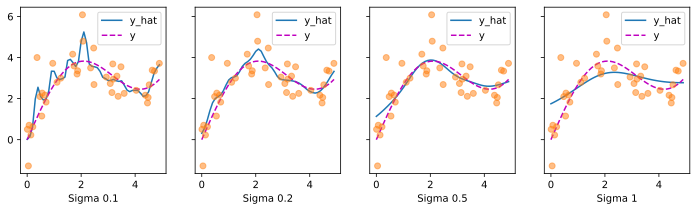

In [10]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

Clearly, the narrower the kernel, the less smooth the estimate. At the same time, it adapts better to the local variations. Let's look at the corresponding attention weights.

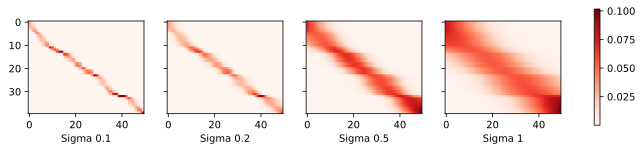

In [11]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

As we would expect, the narrower the kernel, the narrower the range of large attention weights. It is also clear that picking the same width might not be ideal. In fact, Silverman (1986) proposed a heuristic that depends on the local density. Many more such “tricks” have been proposed. It remains a valuable technique to date. For instance, Norelli et al. (2022) used a similar nearest-neighbor interpolation technique to design cross-modal image and text representations.

### Why study a method that is over half a century old?

1) It is one of the earliest precursors of modern attention mechanisms.
2) It is great for visualizstion. 
3) It demonstrates the limits of hand-crafted attention mechanisms. 

A much better strategy is to _learn_ the mechanism, by learning the representation for queries and keys.